In [13]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import uproot
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, TreeMakerSchema

import pickle

ak.behavior.update(candidate.behavior)


# # a = ak.flatten(llp.z[ak.any(ClusterID,axis=1)])
# <Array [908, -694, 859, ... -1.07e+03, -974] type='15 * float32'>
# b = ak.flatten(llp.z)
# <Array [621, 908, -721, ... -1.07e+03, -974] type='63 * float32'>
# ak.flatten(ak.fill_none(ak.mask(llp.z,ak.any(ClusterID,axis=1)),[0]))
# <Array [0, 908, 0, 0, ... 0, -1.07e+03, -974] type='63 * float64'>

def maskAndFill(denom,selection,value):
    numer = ak.mask(denom,selection)
    numer = ak.fill_none(numer, value) #fill none with same structure
    return ak.flatten(numer)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nCscRechits": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("nCscRechits", "nCscRechits", 50, 0, 1000),
            ),
            "nCluster": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("nCluster", "nCluster", 4, 0, 4),
            ),                   
            "ClusterNChamber": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterNChamber", "ClusterNChamber", 10, 0, 10),
            ),                   
            "ClusterMaxChamber": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterMaxChamber", "ClusterMaxChamber", 80, 0, 40),
            ),                   
            "ClusterNStation10": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterNStation10", "ClusterNStation10", 10, 0, 10),
            ),                   
            "ClusterMaxStation": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterMaxStation", "ClusterMaxStation", 10, 0, 10),
            ),
            "ClusterAvgStation10": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterAvgStation10", "ClusterAvgStation10", 40, 0, 10),
            ),            
            "ClusterEta": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterEta", "ClusterEta", 50, 0, 3),
            ),
            "ClusterTime": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterTime", "ClusterTime", 100, -80, 80),
            ),        
            "ClusterTimeSpread": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterTimeSpread", "ClusterTimeSpread", 80, 0, 80),
            ),            
            "clusterID":hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("ClusterEta", "ClusterEta", 50, 0, 3),
                hist.Bin("ClusterAvgStation10", "ClusterAvgStation10", 40, 0, 5),                    
            ),            
            "llp":hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("selection",'pass/fail', 2,0,2),
                hist.Bin("z", "LLP decay Z[cm]", 40, 570, 1050),
                hist.Bin("r", "LLP decay R[cm]", 20, 100, 700),
                hist.Bin("e", "LLP E[GeV]", 20, 0, 250),
                hist.Bin("EMfrac", "LLP EM energy fraction", 40, 0, 1),                            
            ),
            
            "nLeptons": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("nLeptons", "nLeptons", 5, 0, 5),
            ),            
            "lepPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("lepPt", "lepPt", 40, 0, 100),
            ), 
            "nJets": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("nJets", "nJets", 5, 0, 5),
            ),
            "jetPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("jetPt", "jetPt", 50, 50, 300),
            ),          
            "jetMet_dPhi": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("jetMet_dPhi", "jetMet_dPhi", 50, -np.pi, np.pi),
            ),  
            
            "metXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("metXYCorr", "metXYCorr", 50, 0, 500),
            ),            
            "metPhiXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("metPhiXYCorr", "metPhiXYCorr", 50, -np.pi, np.pi),
            ),
            "MT": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("MT", "MT", 50, 0, 200),
            ),            
            "dphi_cluster_MET": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("dphi_cluster_MET", r'$\Delta\phi$(cluster,MET)', 50, 0, np.pi),
            ),        
            "dphi_cluster_lep": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin('llp_matched','cls_llp_matched',2,0,2),
                hist.Bin("dphi", r'$\Delta\phi$(cluster,lep)', 50, 0, np.pi),
            ),
            "gLLP_csc": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_csc", 'gLLP_csc', 2, 0,2),
            ),                                
            "gWPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gWPt", 'gWPt', 50, 0,100),
            ),                    
            "glepdPhi": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_lepdPhi", r'$\Delta\phi$(gLLPp,g_lep)', 50, -np.pi,np.pi),
            ),                    
            "gLepPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLepPt", 'gLepPt', 50, 0,100),
            ),                    
            "gLLP_pt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_pt", 'gLLP_pt', 50, 0,100),
            ),                                            
            
            
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        events = uproot.lazy(events._tree)        

        output["nLeptons"].fill(dataset=dataset,nLeptons=events.nLeptons)
        output["lepPt"].fill(dataset=dataset,lepPt=ak.flatten(events.lepPt))        
        output["nJets"].fill(dataset=dataset,nJets=events.nJets)
        output["jetPt"].fill(dataset=dataset,jetPt=ak.flatten(events.jetPt)) 
        output["jetMet_dPhi"].fill(dataset=dataset,jetMet_dPhi=events.jetMet_dPhi)         
        output["metXYCorr"].fill(dataset=dataset,metXYCorr=events.metXYCorr)        
        output["metPhiXYCorr"].fill(dataset=dataset,metPhiXYCorr=events.metPhiXYCorr)          
        output["gLLP_csc"].fill(dataset=dataset,gLLP_csc=ak.flatten(events.gLLP_csc))        
        output["gWPt"].fill(dataset=dataset,gWPt=events.gWPt)
        output["glepdPhi"].fill(dataset=dataset,gLLP_lepdPhi=ak.flatten(events.gLLP_lepdPhi))        
        output["gLLP_pt"].fill(dataset=dataset,gLLP_pt=ak.flatten(events.gLLP_pt))                
        output["gLepPt"].fill(dataset=dataset,gLepPt=events.gLepPt)                
        output["MT"].fill(dataset=dataset,MT=events.MT)
        
        csc = ak.any(events.gLLP_csc,axis=1)
        events = events[(csc==1)]
        
        lep=ak.zip({
            'pt':events.lepPt ,
            'eta':events.lepEta,
            'phi':events.lepPhi,
            'energy':events.lepE,
        },with_name='PtEtaPhiELorentzVector',
        behavior=vector.behavior    
        )  
        
        llp=ak.zip({
            'pt':events.gLLP_pt,
            'EMfrac':events.gLLP_EMFracE,
            'e':events.gLLP_e,
            'z':events.gLLP_decay_vertex_z ,
            'r':events.gLLP_decay_vertex_r,
        })
        llp = llp[llp.e>0]
            
        cluster= ak.zip(
            {                
                "n":events.nCscRechitClusters3,
                "time":events.cscRechitCluster3Time,
                "timeSpread":events.cscRechitCluster3TimeSpread,
                "eta":events.cscRechitCluster3Eta,
                "phi":events.cscRechitCluster3Phi,        
                "NChamber":events.cscRechitCluster3NChamber,
                "MaxChamber":events.cscRechitCluster3MaxChamber,
                "MaxStation":events.cscRechitCluster3MaxStation,
                "NStation10":events.cscRechitCluster3NStation10,
                "AvgStation10":events.cscRechitCluster3AvgStation10,
                "llp_match":events.cscRechitCluster3_match_gLLP,
                "dphi_cluster_MET":events.cscRechitCluster3MetXYCorr_dPhi,                
            }
        )
        
        ClusterID =((cluster.NStation10>1) & (abs(cluster.eta)<1.9))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==4) & (abs(cluster.eta)<1.8))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==3) & (abs(cluster.eta)<1.6))|\
        ((cluster.NStation10==1) &(abs(cluster.AvgStation10)==2) & (abs(cluster.eta)<1.6))
        
        cluster_dir= ak.zip(
        {
                'pt':ak.ones_like(events.cscRechitCluster3Eta),
                "eta":events.cscRechitCluster3Eta,
                "phi":events.cscRechitCluster3Phi,
                'mass':ak.zeros_like(events.cscRechitCluster3Eta)
            },with_name="PtEtaPhiMLorentzVector",
            behavior=vector.behavior
        )
        
        cls_lep_pair = ak.cartesian({"cls":cluster_dir,'lep':lep},axis=1,nested=True)
        dphi_lep_cls = cls_lep_pair.cls.delta_phi(cls_lep_pair.lep)        
        
        output["dphi_cluster_lep"].fill(dataset=dataset,
                llp_matched=ak.ones_like(ak.flatten(dphi_lep_cls[cluster.llp_match],axis=None)),
                dphi =abs(ak.flatten(dphi_lep_cls[cluster.llp_match],axis=None))
        )
        output["dphi_cluster_lep"].fill(dataset=dataset,
                llp_matched=ak.zeros_like(ak.flatten(dphi_lep_cls[~cluster.llp_match],axis=None)),
                dphi =abs(ak.flatten(dphi_lep_cls[~cluster.llp_match],axis=None))
        )        
        
        #Events with clusterID pass, in llp shape
#         llp_selection = maskAndFill(llp.e,ak.any(ClusterID,axis=1),len(llp.e[0])*[0])        
        llp_selection = maskAndFill(llp.e,ak.any(cluster.llp_match,axis=1),len(llp.e[0])*[0])
        #Convert into selection flag
        #Count only if llp.e>0
        llp_selection = ak.values_astype(llp_selection>0,np.int)        

        
#         print('numer=',maskAndFill(llp.z,ak.any(ClusterID,axis=1),0))
#         print('denom=',ak.flatten(llp.z))
        
        cluster = ak.flatten(cluster[cluster.llp_match])
        
        output["sumw"][dataset] += len(events)
        output['llp'].fill(dataset=dataset,
                            selection=llp_selection,
                            z=ak.flatten(llp.z),
                            r=ak.flatten(llp.r),
                            e=ak.flatten(llp.e),
                           EMfrac=ak.flatten(llp.EMfrac)
                            )
            
        output["nCscRechits"].fill(dataset=dataset,nCscRechits=events.nCscRechits)        
        output["nCluster"].fill(dataset=dataset,nCluster=cluster.n)
        output["ClusterTime"].fill(dataset=dataset,ClusterTime=cluster.time)
        output["ClusterTimeSpread"].fill(dataset=dataset,ClusterTimeSpread=cluster.timeSpread)        
        output["ClusterNChamber"].fill(dataset=dataset,ClusterNChamber=cluster.NChamber)
        output["ClusterMaxChamber"].fill(dataset=dataset,ClusterMaxChamber=np.abs(cluster.MaxChamber))        
        output["ClusterMaxStation"].fill(dataset=dataset,ClusterMaxStation=cluster.MaxStation)
        output["ClusterNStation10"].fill(dataset=dataset,ClusterNStation10=cluster.NStation10)
        output["ClusterAvgStation10"].fill(dataset=dataset,ClusterAvgStation10=cluster.AvgStation10)
        output["ClusterEta"].fill(dataset=dataset,ClusterEta=np.abs(cluster.eta))            
        output["dphi_cluster_MET"].fill(dataset=dataset,dphi_cluster_MET=np.abs(cluster.dphi_cluster_MET))                                

        return output

    def postprocess(self, accumulator):
        return accumulator

In [14]:
fileset = {
    r'HNL,$m_N$=5': [
        '~/eos/llp/HNL/HeavyNeutralLepton_Tree.root',
    ],
#     r'$m_s$=7,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTodddd_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_7_1000.root"
#     ],    
    r'$m_s$=7,$c\tau$=1m': [
        "../ggH_HToSSTodddd_v2/HeavyNeutralLepton_Tree_45_7_1000.root"
    ],        
    r'$m_s$=15,$c\tau$=1m': [
        "../ggH_HToSSTodddd_v2/HeavyNeutralLepton_Tree_45_15_1000.root"
    ],        
    
    
#     r'$m_s$=15,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_15_1000.root"
#     ],    
#     r'WJetstoLNu': [
#         "~/eos/llp/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/HeavyNeutralLepton_Tree.root"
#     ],    
    
    
#     r'$m_s$=40,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_1000.root"
#     ],
#     r'$m_s$=40,$c\tau$=10m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_10000.root"
#     ],    
#     r'$m_s$=55,$c\tau$=1m': [
#         "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_55_1000.root"
#     ]    
}

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
#     maxchunks=2,
#     chunksize=10000
)



Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/4 [00:00<?, ?chunk/s]

In [15]:
with open('HNL_histograms.pickle','wb') as f:
    pickle.dump(out,f)

In [16]:
with open('HNL_histograms.pickle','rb') as f:
    out = pickle.load(f)

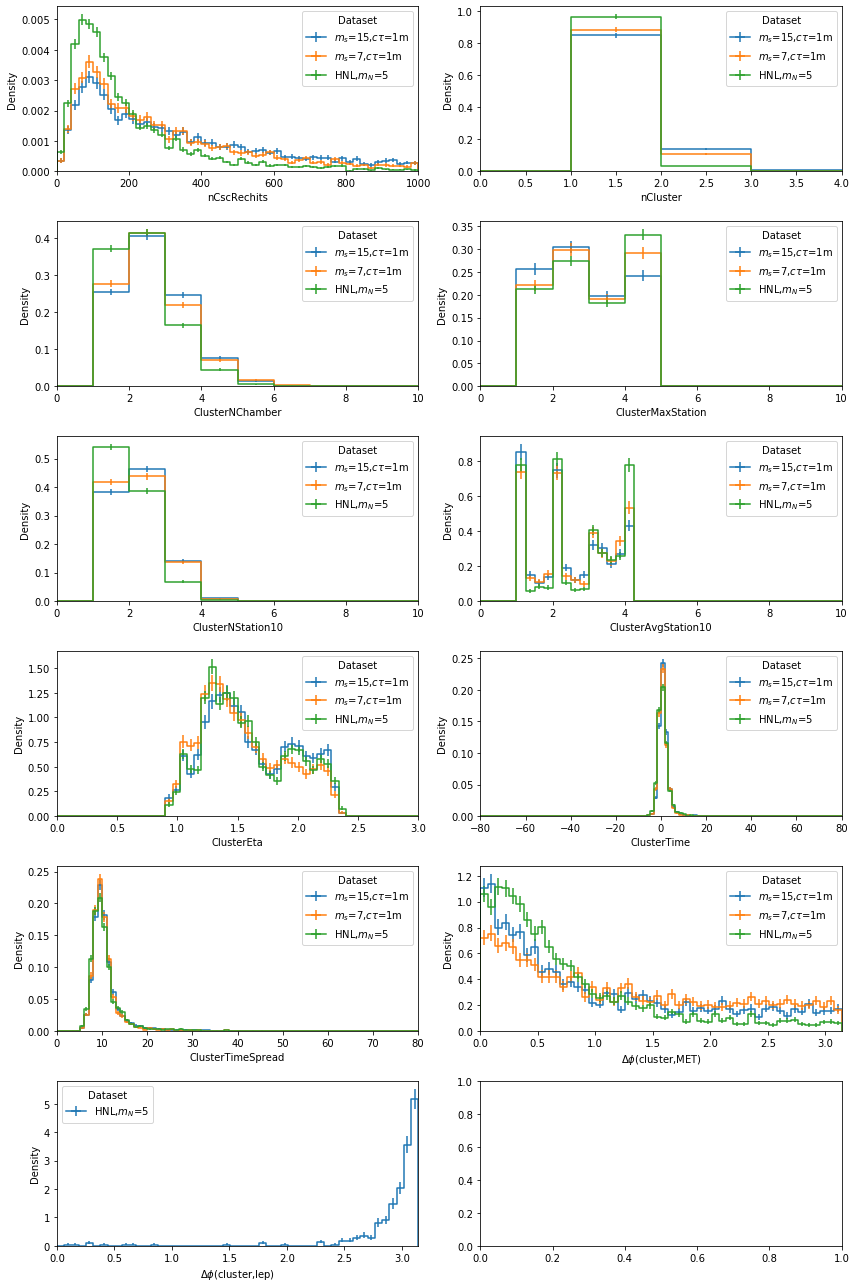

In [112]:

hists = [
    out["nCscRechits"],
    out["nCluster"],
    out['ClusterNChamber'],
#     out['ClusterMaxChamber'],
    out['ClusterMaxStation'],
    out['ClusterNStation10'],
    out['ClusterAvgStation10'],
    out['ClusterEta'],    
    out['ClusterTime'],
    out['ClusterTimeSpread'],
    out['dphi_cluster_MET'],
    out['dphi_cluster_lep'][2:].project('dphi','dataset')
]

ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
    h.label='Density'
    hist.plot1d(h[0:3],ax=axs[i], overlay='dataset',density=True,clear=False)

plt.tight_layout()
plt.show()

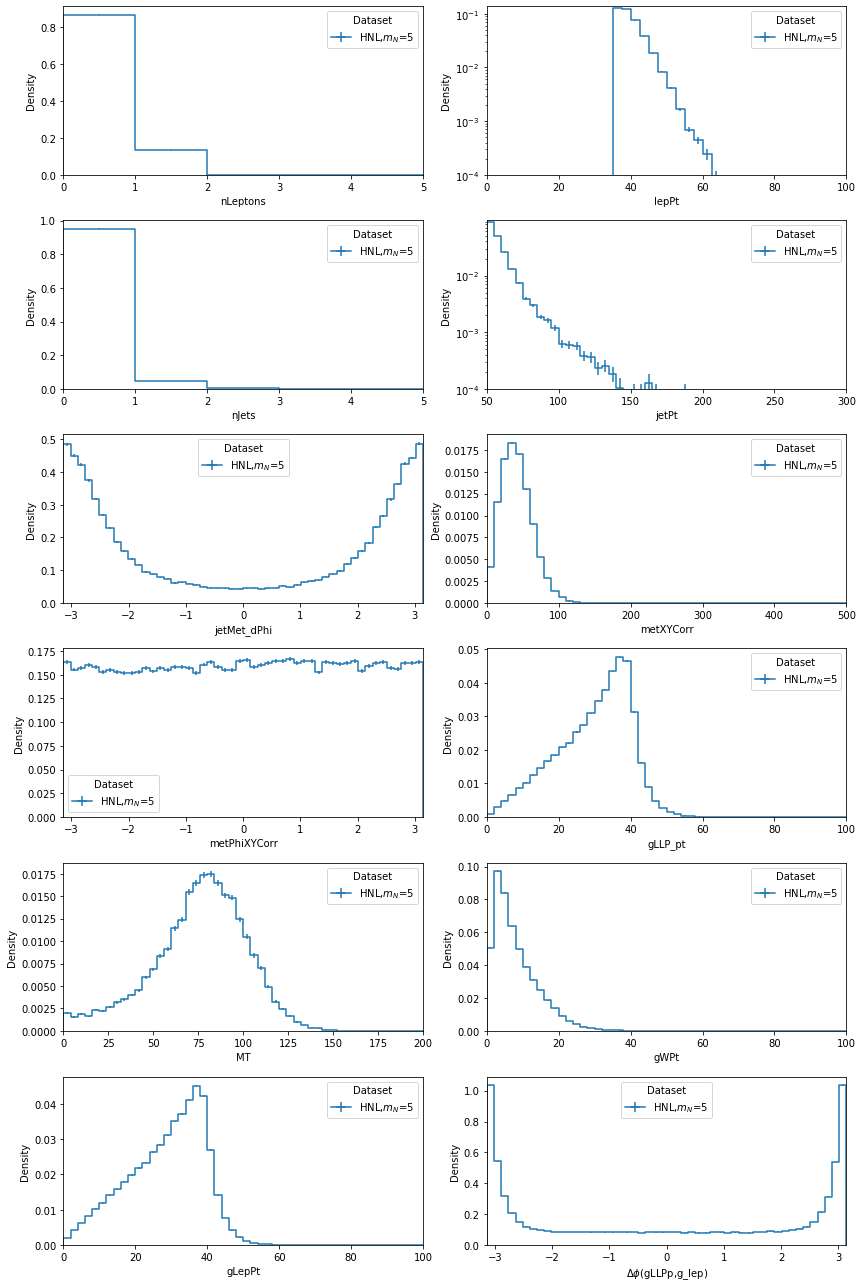

In [109]:
hists = [
    out["nLeptons"][2:],
    out["lepPt"][2:],
    out['nJets'][2:],
    out['jetPt'][2:],
    out['jetMet_dPhi'][2:],    
    out['metXYCorr'][2:],
    out['metPhiXYCorr'][2:],  
    out['gLLP_pt'][2:],
    out['MT'][2:],    
    out['gWPt'][2:],     
    out['gLepPt'][2:],         
    out['glepdPhi'][2:],             
]


ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
    h.label='Density'
#     print(i)
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)
axs[1].set_ylim(1e-4,None)
axs[1].set_yscale('log')    
axs[3].set_ylim(1e-4,None)
axs[3].set_yscale('log')
# axs[4].set_ylim(1e-4,None)
# axs[4].set_yscale('log')
# axs[-3].set_ylim(1e-4,None)
# axs[-3].set_yscale('log')
plt.tight_layout()

h = out["gLLP_csc"]
ax = hist.plot1d(h, overlay='dataset',density=True,clear=False)
print("Efficiency in CSC:")
for ds,arr in h.values().items():
    print(ds,"{:.3f}".format(arr[1]/np.sum(arr)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f314b5c9320>,
      dtype=object)

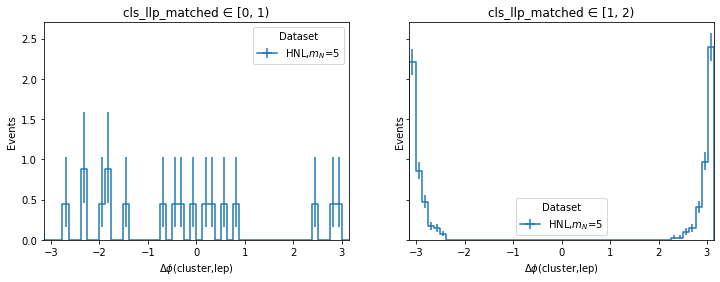

In [10]:
h = out['dphi_cluster_lep']
hist.plotgrid(
    h,
    col='llp_matched',
    overlay='dataset',
    density=True,
)

In [37]:
import matplotlib.patches as patches

def plotEff_efrac(h,ax,axis='e'):
    h_pass=h.integrate('selection',slice(1,None))
    h_pass.label='Signal Efficiency'

    h_EMfrac_p9=h.integrate("EMfrac",slice(0.5,None))
    h_EMfrac_p9_pass=h_EMfrac_p9.integrate("selection",slice(1,None))
    h_EMfrac_p9_pass.label='Signal Efficiency'
    
    h_EMfrac_low=h.integrate("EMfrac",slice(None,0.5))
    h_EMfrac_low_pass=h_EMfrac_low.integrate("selection",slice(1,None))
    h_EMfrac_low_pass.label='Signal Efficiency'
    
    hist.plotratio(
    ax=ax,
    num=h_pass.project(axis),
    denom=h.project(axis),
    error_opts={ 'marker': '.'},
    unc='clopper-pearson',
    label='Inclusive'
    )

    hist.plotratio(
        ax=ax,
        num=h_EMfrac_p9_pass.project(axis),
        denom=h_EMfrac_p9.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac>0.5'
    )
    hist.plotratio(
        ax=ax,
        num=h_EMfrac_low_pass.project(axis),
        denom=h_EMfrac_low.project(axis),
        error_opts={ 'marker': '.'},
        unc='clopper-pearson',
        clear=False,
        label='EMfrac<0.5'
    )    
    ax.legend(loc='best')
    return ax

def plotEff(h_list,ax,axis='e'):
    for h in h_list:
        h_pass=h.integrate('selection',slice(1,None))
        h_pass.label='Signal Efficiency'
        
        hist.plotratio(
            ax=ax,
            num=h_pass.project(axis),
            denom=h.project(axis),
            error_opts={'marker': '.'},
            unc='clopper-pearson',
            label=h.identifiers('dataset')[0].name,
            clear=False
        )

    ax.legend(loc='best')
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-110 ,y_max*0.05, "Inner ring", fontsize=15)
    ax.text(350+15 ,y_max*0.05, "Outer ring", fontsize=15)
    return ax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

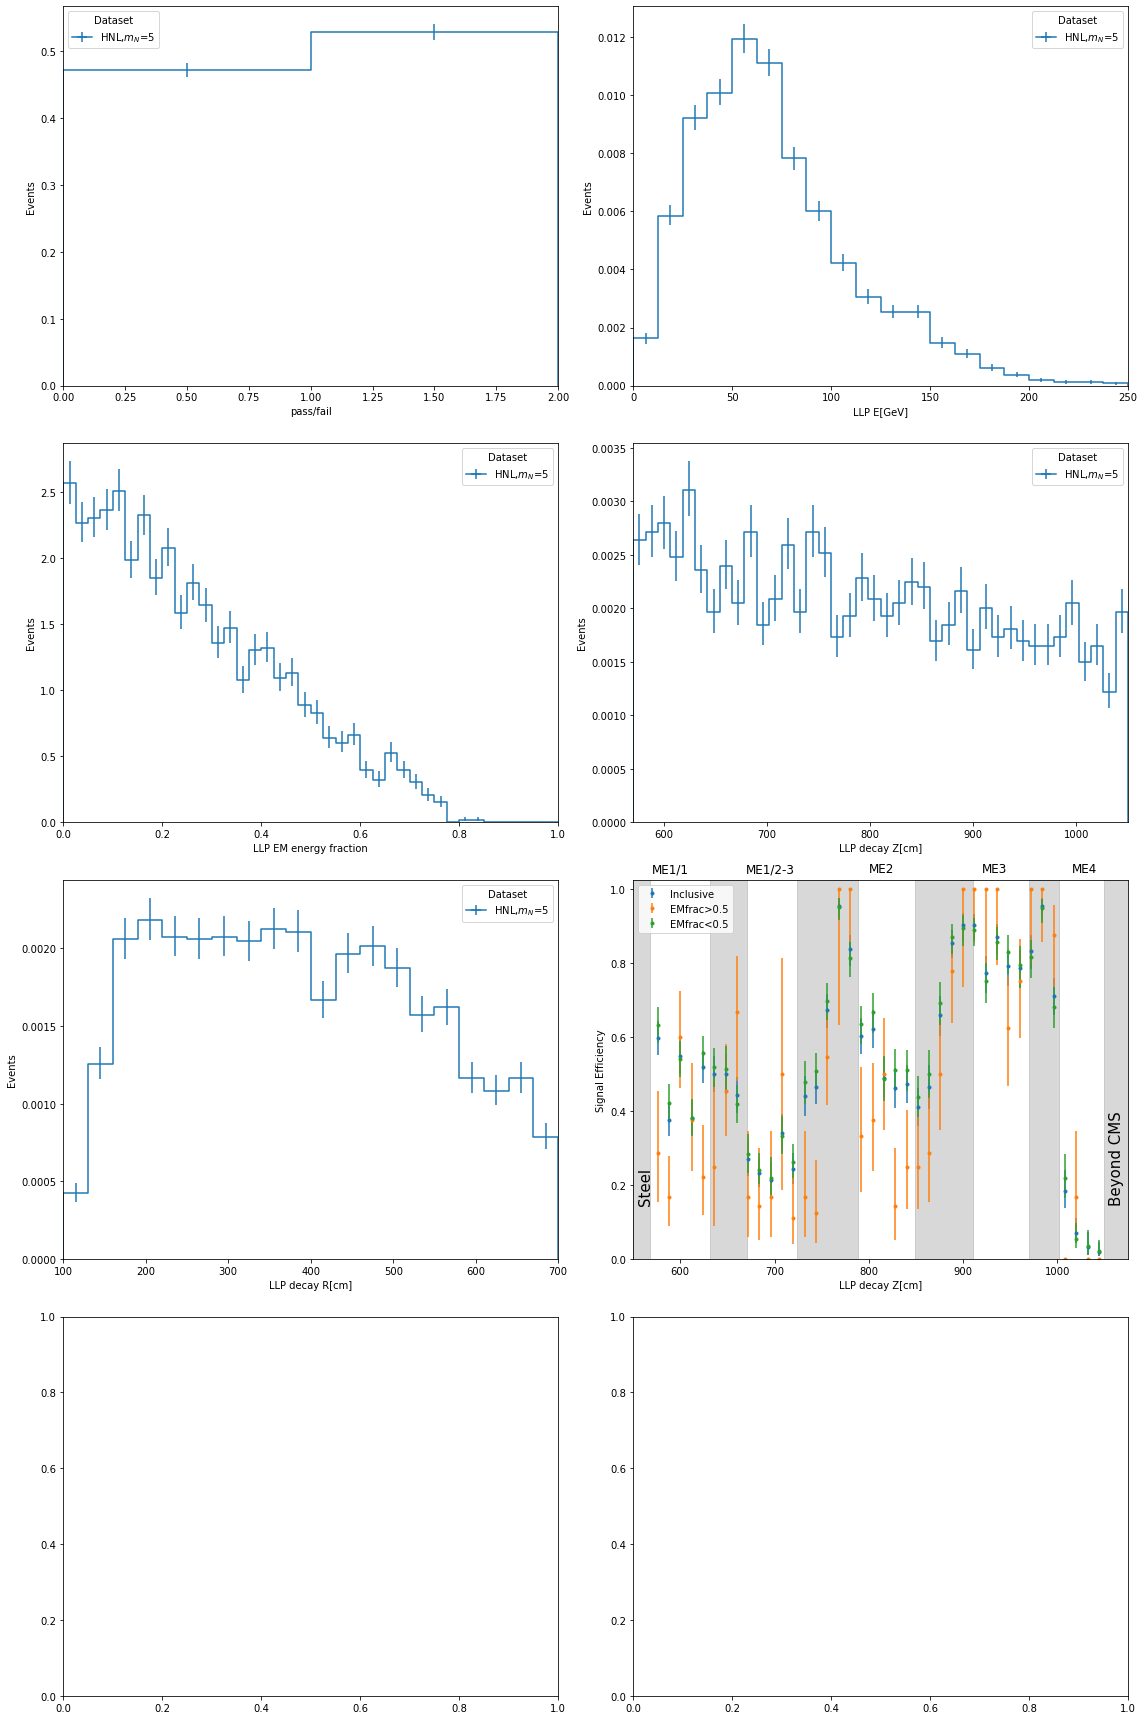

In [41]:
h=out['llp'][2:]

ncols=2
nrows=4
figsize=(8,6)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs=axs.flatten()

for i,d in enumerate(['selection','e','EMfrac','z','r']):
    hist.plot1d(h.project(d,'dataset'),ax=axs[i],overlay="dataset",density=True)

plotEff_efrac(         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5',                  
         ],axs[5],'z')    
    
axs[5] = drawCSCz(axs[5])    
# plotEff([         
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#          h[r'HNL,$m_N$=5'],                  
#          ],axs[5],'e')
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[6],'z')
# axs[6].set_ylim(0,2)
# axs[6] = drawCSCz(axs[6])
# plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
#         h[r'HNL,$m_N$=5'],         
#          ],axs[7],'r')
# axs[7] = drawCSCr(axs[7])
plt.tight_layout()

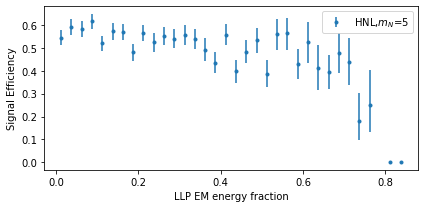

In [29]:

h=out['llp']

ncols=1
nrows=1
figsize=(6,3)

fig, ax = plt.subplots(figsize=figsize)


plotEff([
#          h[r'$m_s$=15,$c\tau$=1m'],    
#          h[r'$m_s$=7,$c\tau$=1m'], 
         h[r'HNL,$m_N$=5'],         
         ],ax,'EMfrac')
# ax=drawCSCz(ax)
ax.legend(loc=1)

plt.tight_layout()